*We will begin with standard imports/definitons: we define the SmallAlexNet function (as was defined in the question), and the unpickling function.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.utils.data as data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns


class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallAlexNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 384, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(384, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.flat_size = 192 * 8 * 8
        
        self.fc1 = nn.Linear(self.flat_size, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = F.local_response_norm(x, size=5, alpha=1e-4, beta=0.75, k=2)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = F.local_response_norm(x, size=5, alpha=1e-4, beta=0.75, k=2)
        
        x = x.view(-1, self.flat_size)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following function is used to load the dataset, which is currently in batches.

In [2]:
def load_cifar10(dataset_path="dataset"):
    data = []
    labels = []

    for i in range(1, 6):  # data_batch_1 to data_batch_5
        batch = unpickle(f"{dataset_path}/data_batch_{i}")
        data.append(batch[b'data'])
        labels.extend(batch[b'labels'])

    data = np.vstack(data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # reshape to (50000, 32, 32, 3)
    labels = np.array(labels)

    return data, labels

Data, Labels = load_cifar10()
print(f"Dataset Shape: {Data.shape}, Labels Shape: {Labels.shape}")
meta = unpickle("dataset/batches.meta")
label_names = [label.decode('utf-8') for label in meta[b'label_names']]
print(label_names)

Dataset Shape: (50000, 32, 32, 3), Labels Shape: (50000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


This is what each class in the dataset looks like:

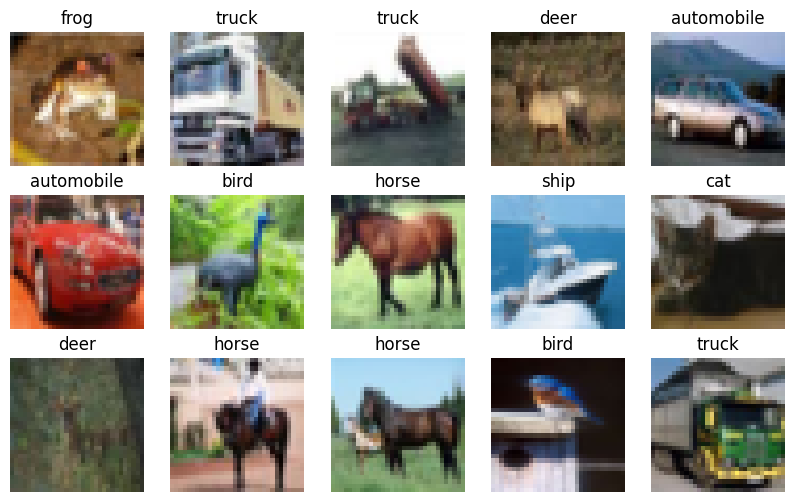

In [3]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    img = Data[i]
    ax.imshow(img)
    ax.set_title(label_names[Labels[i]])
    ax.axis("off")
plt.show()

Now, we load in the model and test its accuracy on the full dataset, amongst other parameters.

Model Accuracy on Custom CIFAR-10 Dataset: 78.92%

Classification Report:
               precision    recall  f1-score   support

    airplane       0.79      0.78      0.79      5000
  automobile       0.89      0.91      0.90      5000
        bird       0.76      0.69      0.72      5000
         cat       0.53      0.82      0.65      5000
        deer       0.79      0.70      0.74      5000
         dog       0.84      0.68      0.75      5000
        frog       0.92      0.73      0.82      5000
       horse       0.98      0.76      0.86      5000
        ship       0.80      0.90      0.85      5000
       truck       0.80      0.92      0.86      5000

    accuracy                           0.79     50000
   macro avg       0.81      0.79      0.79     50000
weighted avg       0.81      0.79      0.79     50000



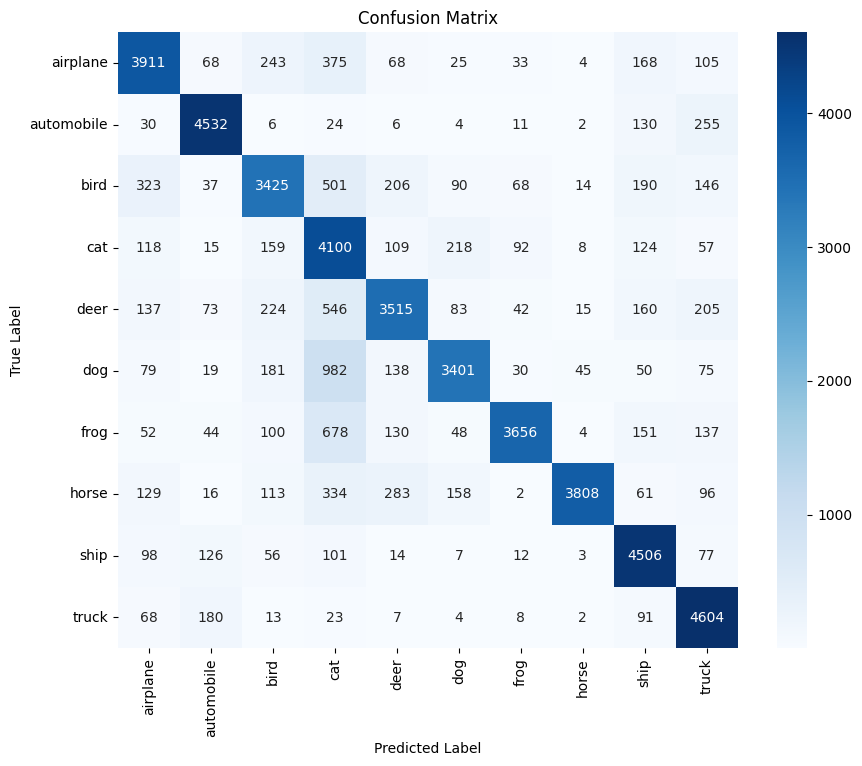

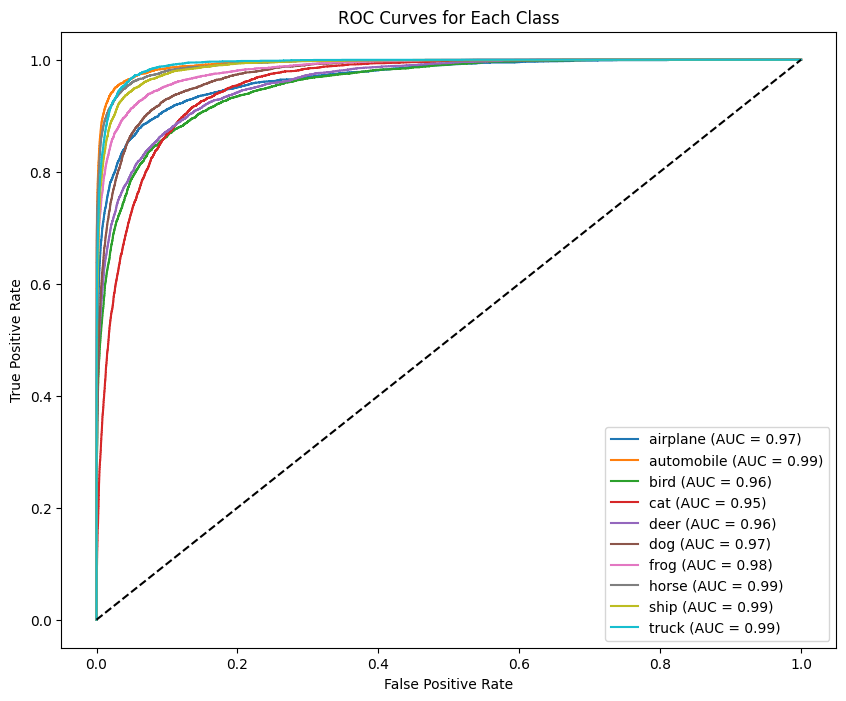

AUC Scores:
airplane: 0.97
automobile: 0.99
bird: 0.96
cat: 0.95
deer: 0.96
dog: 0.97
frog: 0.98
horse: 0.99
ship: 0.99
truck: 0.99


In [81]:
X_test_tensor = torch.tensor(Data, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(Labels, dtype=torch.long)

X_test_tensor = (X_test_tensor - X_test_tensor.mean(dim=(1, 2, 3), keepdim=True)) / X_test_tensor.std(dim=(1, 2, 3), keepdim=True)

test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = data.DataLoader(test_dataset, batch_size=100, shuffle=False)

device = "cpu"

Model = SmallAlexNet()  
Model.load_state_dict(torch.load("model.pt", map_location=device))
Model.to(device)

correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = Model(images)
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = 100 * correct / total
print(f"Model Accuracy on Custom CIFAR-10 Dataset: {accuracy:.2f}%")

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]))

# confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
            yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# AUC for each class
y_true = np.eye(10)[np.array(all_labels)]  # cnvert labels to one-hot encoding
all_probs = np.array(all_probs)
auc_scores = {}

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    auc = roc_auc_score(y_true[:, i], all_probs[:, i])
    auc_scores[class_name] = auc
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # 45 degree line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.show()

print("AUC Scores:")
for class_name, auc in auc_scores.items():
    print(f"{class_name}: {auc:.2f}")


Test Dataset Shape: (10000, 32, 32, 3), Test Labels Shape: (10000,)
Model Accuracy on Custom CIFAR-10 Dataset: 68.45%

Classification Report:
               precision    recall  f1-score   support

    airplane       0.68      0.67      0.67      1000
  automobile       0.83      0.82      0.82      1000
        bird       0.65      0.59      0.62      1000
         cat       0.41      0.65      0.50      1000
        deer       0.66      0.61      0.63      1000
         dog       0.71      0.55      0.62      1000
        frog       0.85      0.66      0.75      1000
       horse       0.92      0.65      0.76      1000
        ship       0.71      0.82      0.77      1000
       truck       0.69      0.82      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.71      0.68      0.69     10000
weighted avg       0.71      0.68      0.69     10000



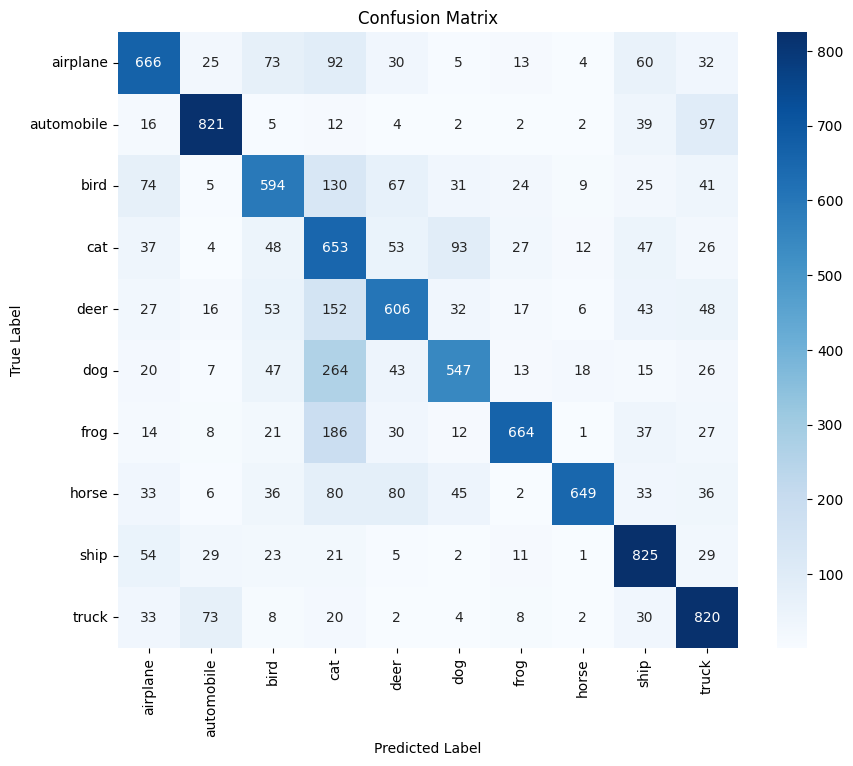

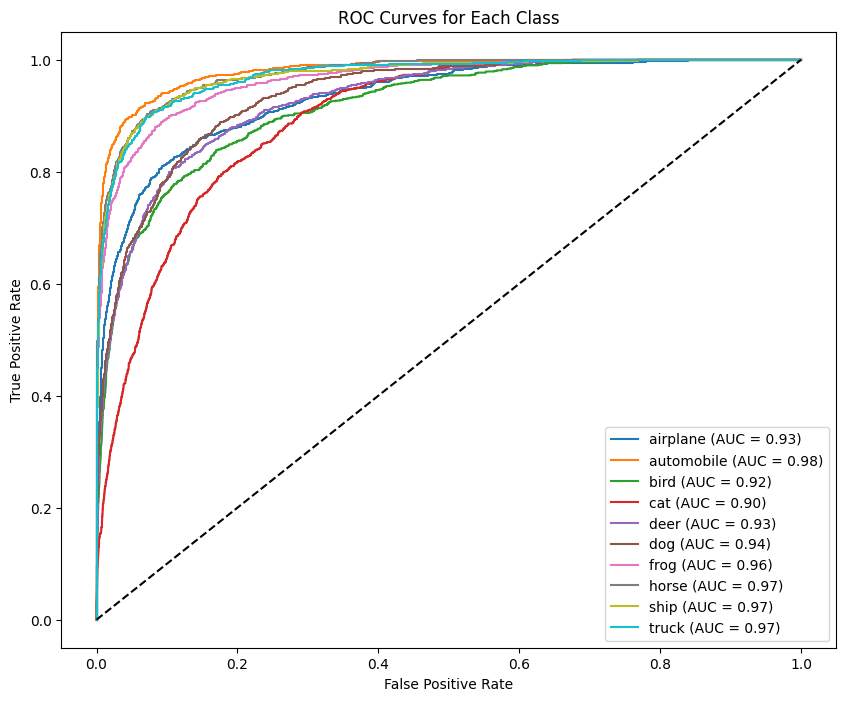

AUC Scores:
airplane: 0.93
automobile: 0.98
bird: 0.92
cat: 0.90
deer: 0.93
dog: 0.94
frog: 0.96
horse: 0.97
ship: 0.97
truck: 0.97


In [80]:
test_batch = unpickle("dataset/test_batch")
X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_batch[b'labels'])

print(f"Test Dataset Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}")

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_test_tensor = (X_test_tensor - X_test_tensor.mean(dim=(1, 2, 3), keepdim=True)) / X_test_tensor.std(dim=(1, 2, 3), keepdim=True)

test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = data.DataLoader(test_dataset, batch_size=100, shuffle=False)

device = "cpu"

correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = Model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = 100 * correct / total
print(f"Model Accuracy on Custom CIFAR-10 Dataset: {accuracy:.2f}%")
# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
            yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

y_true = np.eye(10)[np.array(all_labels)]
all_probs = np.array(all_probs)
auc_scores = {}

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    auc = roc_auc_score(y_true[:, i], all_probs[:, i])
    auc_scores[class_name] = auc
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.show()

print("AUC Scores:")
for class_name, auc in auc_scores.items():
    print(f"{class_name}: {auc:.2f}")


Untrained Model Accuracy on Custom CIFAR-10 Test Set: 10.00%

Untrained Model Classification Report:
               precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.10      1.00      0.18      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


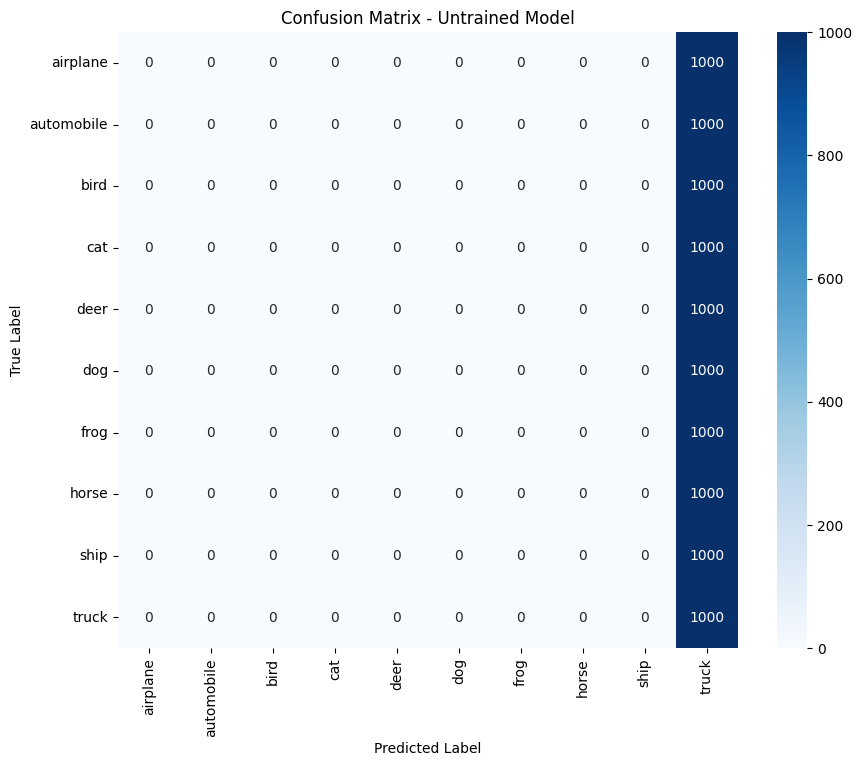

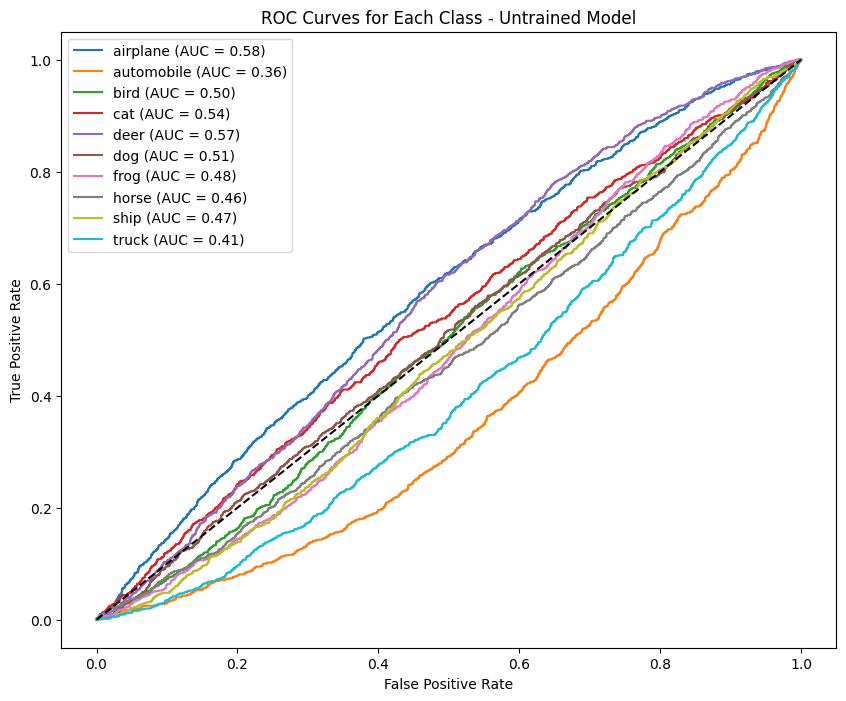

AUC Scores for Untrained Model:
airplane: 0.58
automobile: 0.36
bird: 0.50
cat: 0.54
deer: 0.57
dog: 0.51
frog: 0.48
horse: 0.46
ship: 0.47
truck: 0.41

Comparison of Trained vs Untrained Model
Trained Model Accuracy: 63.92%
Untrained Model Accuracy: 10.00%


In [ ]:
Untrained_Model = type(Model)()
Untrained_Model.to(device)
Untrained_Model.eval()

correct_untrained = 0
total_untrained = 0
all_preds_untrained = []
all_probs_untrained = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = Untrained_Model(images)
        probs = torch.softmax(outputs, dim=1)  # softmax
        _, predicted = torch.max(outputs, 1)

        total_untrained += labels.size(0)
        correct_untrained += (predicted == labels).sum().item()

        all_preds_untrained.extend(predicted.cpu().numpy())
        all_probs_untrained.extend(probs.cpu().numpy())

# Compute accuracy
accuracy_untrained = 100 * correct_untrained / total_untrained
print(f"Untrained Model Accuracy on Custom CIFAR-10 Test Set: {accuracy_untrained:.2f}%")

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


all_labels_untrained = all_labels

print("\nUntrained Model Classification Report:\n", classification_report(
    all_labels_untrained, all_preds_untrained, target_names=[
        "airplane", "automobile", "bird", "cat", "deer", "dog", 
        "frog", "horse", "ship", "truck"
    ]
))

conf_matrix_untrained = confusion_matrix(all_labels_untrained, all_preds_untrained)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_untrained, annot=True, fmt="d", cmap="Blues",
            xticklabels=["airplane", "automobile", "bird", "cat", "deer", 
                         "dog", "frog", "horse", "ship", "truck"],
            yticklabels=["airplane", "automobile", "bird", "cat", "deer", 
                         "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Untrained Model")
plt.show()

y_true_untrained = np.eye(10)[np.array(all_labels_untrained)] 
all_probs_untrained = np.array(all_probs_untrained)
auc_scores_untrained = {}

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]):
    fpr, tpr, _ = roc_curve(y_true_untrained[:, i], all_probs_untrained[:, i])
    auc = roc_auc_score(y_true_untrained[:, i], all_probs_untrained[:, i])
    auc_scores_untrained[class_name] = auc
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class - Untrained Model")
plt.legend()
plt.show()

print("AUC Scores for Untrained Model:")
for class_name, auc in auc_scores_untrained.items():
    print(f"{class_name}: {auc:.2f}")

print("\nComparison of Trained vs Untrained Model")
print(f"Trained Model Accuracy: {accuracy:.2f}%")
print(f"Untrained Model Accuracy: {accuracy_untrained:.2f}%")


*Making the Attacks* 

We will begin by loading the images we will use. 

In [ ]:
def reassign_images(idx_x, idx_b, Data, Labels, Model, label_names, device="cpu"):
    # idx_x index of image that we want to modify
    # idx_b = index of target image: the image will be modified to be classified as the same class as this 

    image_x_np = Data[idx_x]  
    image_b_np = Data[idx_b] 

    # convert numpy arrays to PyTorch tensors, permute to [C, H, W], and normalize
    image_x = torch.from_numpy(image_x_np).permute(2, 0, 1).float() / 255.0
    image_b = torch.from_numpy(image_b_np).permute(2, 0, 1).float() / 255.0

    # batch dimension added
    image_x = image_x.unsqueeze(0)
    image_b = image_b.unsqueeze(0)

    device = torch.device("cpu")
    image_x, image_b = image_x.to(device), image_b.to(device)

    Model.eval()

    # inference on both images
    with torch.no_grad():
        output_x = Model(image_x)
        output_b = Model(image_b)

    # predicted labels
    _, predicted_label_x = torch.max(output_x, 1)
    _, predicted_label_b = torch.max(output_b, 1)

    # print results
    print(f"Predicted class for image_x: {label_names[predicted_label_x.item()]}")
    print(f"Predicted class for image_b: {label_names[predicted_label_b.item()]}")

    return image_x, image_b

*Poison frog attack*

So, we want the original image (which is being classified as an airplane) to be perturbed to go to ship instead. Now, we define the poison frog function.

In [131]:
def poisoned_frog_attack(model, x, b, target_class=None, beta=0.5, lr=0.01, 
                        iterations=100, epsilon=0.03, use_ce=False):
    """
    Improved Poisoned Frog Attack with flexible loss options and constraints.
    
    Args:
    - model: Trained PyTorch model
    - x: Original image (Tensor of shape [1, C, H, W])
    - b: Target image (Tensor of shape [1, C, H, W])
    - target_class: Optional target class (if None, uses b's predicted class)
    - beta: Weight for perceptual similarity
    - lr: Learning rate for attack
    - iterations: Number of attack steps
    - epsilon: Maximum perturbation allowed (L∞ constraint)
    - use_ce: Use cross-entropy loss instead of MSE for classification
    
    Returns:
    - x_adv: Adversarial image
    """
    x_adv = x.clone().detach().requires_grad_(True)
    
    with torch.no_grad():
        if target_class is None:
            target_class = model(b).argmax(dim=1)
    
    # initialize optimizer - SGD with momentum
    optimizer = torch.optim.SGD([x_adv], lr=lr, momentum=0.9)
    
    for _ in range(iterations):
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(x_adv)
        
        # classification loss
        if use_ce:
            ce_loss = F.cross_entropy(outputs, target_class)
        else:
            with torch.no_grad():
                f_b = model(b)
            ce_loss = F.mse_loss(outputs, f_b)
        
        # perceptual similarity loss
        sim_loss = F.mse_loss(x_adv, b)
        
        # combined loss function
        loss = ce_loss + beta * sim_loss
        
        # backward pass
        loss.backward()
        
        with torch.no_grad():
            grad_sign = x_adv.grad.sign()
            x_adv.data = x_adv - lr * grad_sign
            
            # Apply L∞ constraint and valid range
            x_adv.data = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
            x_adv.data = torch.clamp(x_adv, 0, 1)
        
    return x_adv.detach()

def show_images(original, adversarial, title="Original vs Adversarial"):
    transform = transforms.ToPILImage()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # cinverting image format
    axes[0].imshow(transform(original.squeeze(0).cpu()))  # original image
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(transform(adversarial.squeeze(0).cpu()))  # adversarial image
    axes[1].set_title("Adversarial Image")
    axes[1].axis("off")

    plt.suptitle(title)
    plt.show()

In [134]:
image_x, image_b = reassign_images(10202, 3000, Data, Labels, Model, label_names)

Predicted class for image_x: airplane
Predicted class for image_b: ship


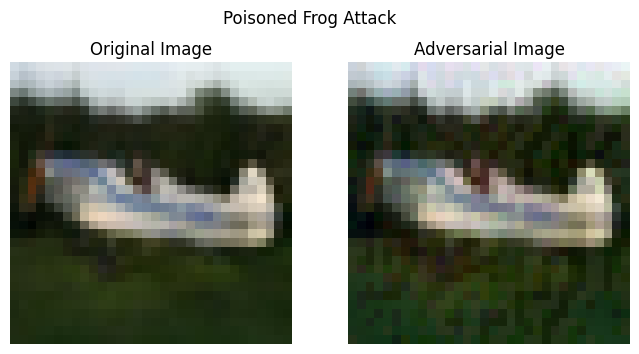

In [135]:
adv_frog = poisoned_frog_attack(Model, image_x, image_b)
show_images(image_x, adv_frog, "Poisoned Frog Attack")

In [136]:
idx = Model(adv_frog.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")

Predicted class by Model: ship


Clearly, poison frog is working! An image which was previously being classified as airplane is now going to ship.

In [60]:
image_x, image_b = reassign_images(30111, 10202, Data, Labels, Model, label_names)

Predicted class for image_x: deer
Predicted class for image_b: airplane


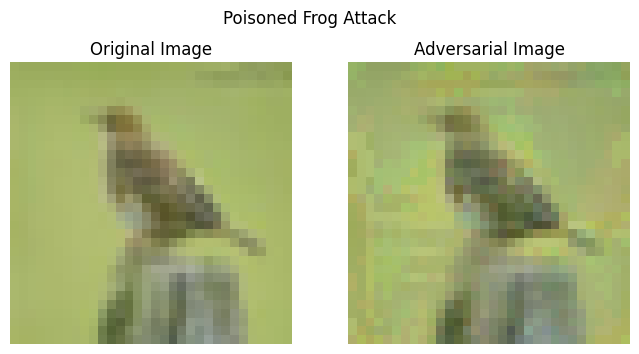

Predicted class by Model: airplane


In [ ]:
adv_frog = poisoned_frog_attack(Model, image_x, image_b)
show_images(image_x, adv_frog, "Poisoned Frog Attack")

idx = Model(adv_frog.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")

In [71]:
image_x, image_b = reassign_images(41000, 10202, Data, Labels, Model, label_names)

Predicted class for image_x: deer
Predicted class for image_b: airplane


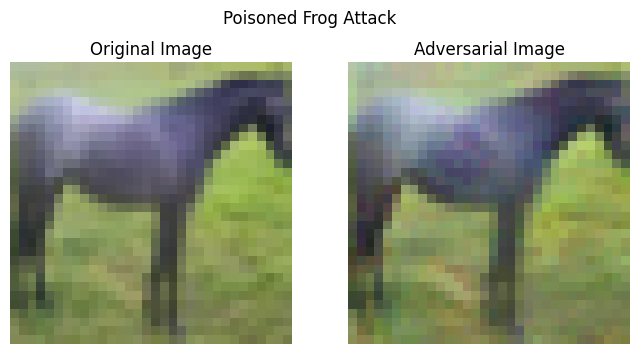

Predicted class by Model: airplane


In [ ]:
adv_frog = poisoned_frog_attack(Model, image_x, image_b)
show_images(image_x, adv_frog, "Poisoned Frog Attack")

idx = Model(adv_frog.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")

*Deep Fool Attack*

The intution behind Deep Fool is pretty simple: we want to find the smallest perturbation that will send the target class to any class that isn't the current one. We will use the airplane image from above:

In [73]:
import torch
import torch.nn.functional as F

def deepfool(image, model, num_classes=10, max_iters=50, epsilon=1e-6):
    # make a copy of the image and enable gradient tracking
    image = image.clone().detach().requires_grad_(True)
    model.eval()  # set the model to evaluation mode

    # get the initial prediction of the model
    with torch.no_grad():
        logits = model(image)
    _, label = torch.max(logits, dim=1)  # get the predicted class
    label = label.item()  # convert to a scalar

    # initialize perturbed image and total perturbation
    perturbed_image = image.clone().detach()
    r_tot = torch.zeros_like(image)

    # iterate up to max_iters to find the minimal perturbation
    for _ in range(max_iters):
        perturbed_image.requires_grad_(True)  # enable gradient tracking
        perturbed_image.retain_grad()  # retain gradients for later use

        logits = model(perturbed_image)  # get model predictions
        sorted_indices = torch.argsort(logits, descending=True)[0][:num_classes]  # get top classes
        label_logits = logits[0, label]  # get the logit for the true class

        min_perturbation = float("inf")
        best_w = None  # initialize best perturbation direction

        # iterate over top competing classes to find the minimal perturbation
        for k in sorted_indices:
            if k == label:
                continue

            model.zero_grad() 
            logits[0, k].backward(retain_graph=True)  # compute gradient for class k

            grad_k = perturbed_image.grad.clone() 
            perturbed_image.grad.zero_()  
            label_logits.backward(retain_graph=True)  
            grad_label = perturbed_image.grad.clone()  # store the gradient for the true class

            w_k = grad_k - grad_label  # compute difference in gradients
            f_k = logits[0, k] - label_logits  # difference in logits

            perturbation = abs(f_k) / (torch.norm(w_k) + epsilon)  # compute the required perturbation

            if perturbation < min_perturbation:  # update if a smaller perturbation is found
                min_perturbation = perturbation
                best_w = w_k

        if min_perturbation == float("inf") or best_w is None: 
            break

        # compute the perturbation step and update total perturbation
        r_i = (min_perturbation + epsilon) * best_w / torch.norm(best_w)
        r_tot += r_i

        # update the perturbed image and ensure pixel values are within [0,1]
        perturbed_image = (image + r_tot).detach().clone()
        perturbed_image.requires_grad_(True)
        perturbed_image.retain_grad()
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        # check if the image has been misclassified
        with torch.no_grad():
            new_logits = model(perturbed_image)
            new_label = torch.argmax(new_logits, dim=1).item()

        if new_label != label:  # stop if misclassification occurs
            break

    return perturbed_image.detach(), r_tot.detach()


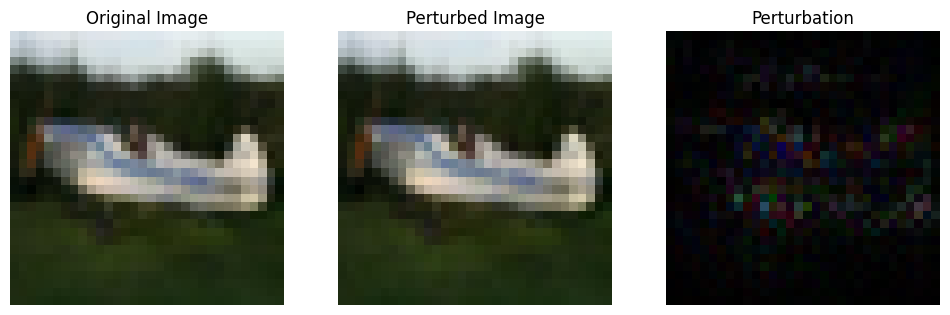

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
image = image_x
perturbed_image, perturbation = deepfool(image, Model)

def show_attack_results(original, perturbed, perturbation, title="Comparison of Original and Attacked Image, and Perturbation"):
    to_pil = transforms.ToPILImage()

    # converting them to same format, as they seem to be coming out differently
    original_img = to_pil(original.squeeze(0))
    perturbed_img = to_pil(perturbed.squeeze(0))

    # normalising the perturbation
    perturbation_img = to_pil(torch.clamp(perturbation.abs() * 10, 0, 1).squeeze(0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(perturbed_img)
    axes[1].set_title("Perturbed Image")
    axes[1].axis("off")

    axes[2].imshow(perturbation_img, cmap="gray")
    axes[2].set_title("Perturbation")
    axes[2].axis("off")

    plt.show()

show_attack_results(image_x, perturbed_image, perturbation)


In [ ]:
idx = Model(perturbed_image.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")

Predicted class by Model: ship


Thus, we have a perturbed image, which produces changes that are barely perceptible by the human eye, but are enough for the model to misclassify.

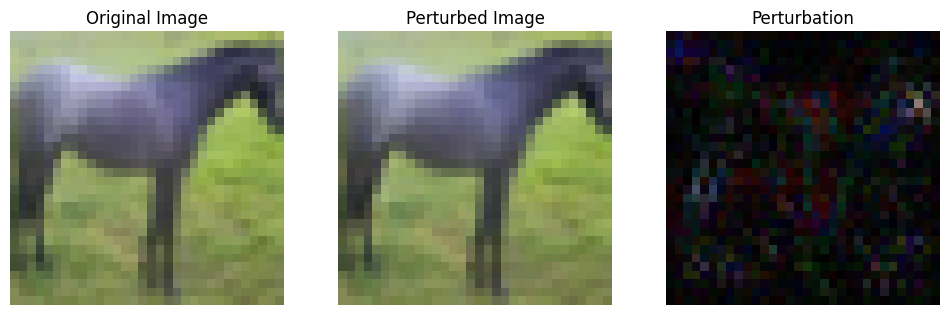

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
image = image_x
perturbed_image, perturbation = deepfool(image, Model)

show_attack_results(image_x, perturbed_image, perturbation)

In [76]:
idx = Model(perturbed_image.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")


Predicted class by Model: horse


This example is particularly interesting, becaus the image was originally being classified as a deer (incorrectly), and it is now going to horse, which is in fact the correct answer.

In [77]:
image_x, image_b = reassign_images(30111, 10202, Data, Labels, Model, label_names)

Predicted class for image_x: deer
Predicted class for image_b: airplane


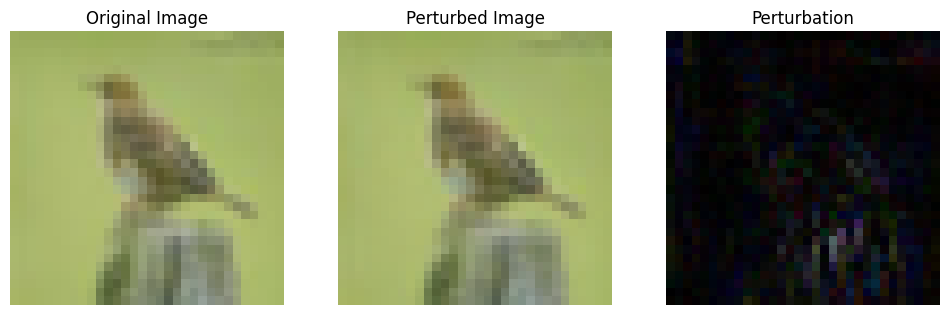

In [78]:
transform = transforms.Compose([
    transforms.ToTensor()
])
image = image_x
perturbed_image, perturbation = deepfool(image, Model)

show_attack_results(image_x, perturbed_image, perturbation)

In [79]:
idx = Model(perturbed_image.to(device)).argmax(1).item()
print(f"Predicted class by Model: {label_names[idx]}")

Predicted class by Model: cat


This one has gone from being a deer to a cat.